In [78]:
## import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
#Base Imports
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#Pre Processing Imports
import re
import nltk
nltk.download('omw-1.4')
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.tokenize import RegexpTokenizer 
from nltk.util import ngrams
from nltk.stem import WordNetLemmatizer
stop_words = set(stopwords.words("english"))
lemmatizer= WordNetLemmatizer()
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB , MultinomialNB  
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score ,train_test_split ,ParameterGrid
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report , confusion_matrix,accuracy_score ,  roc_curve  , auc , roc_auc_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)


[nltk_data] Downloading package omw-1.4 to /Users/anthony/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/anthony/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/anthony/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [79]:
df = pd.read_csv('IMDB_Dataset.csv')

## Exploratory Data Analysis

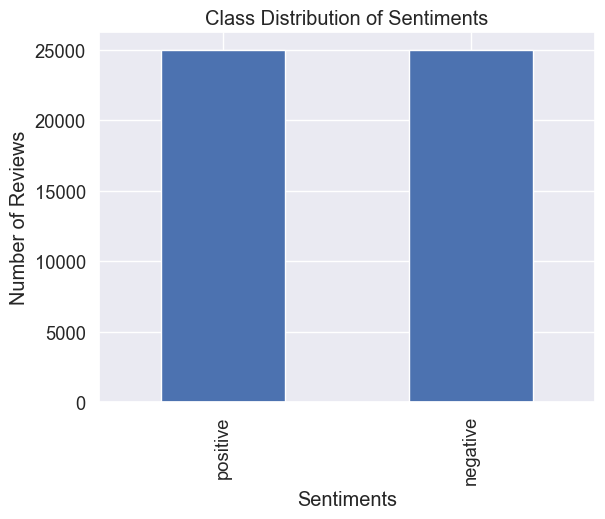

In [80]:
class_counts = df['sentiment'].value_counts()
class_counts.plot(kind='bar')
plt.title('Class Distribution of Sentiments')
plt.xlabel('Sentiments')
plt.ylabel('Number of Reviews')
plt.show()

In [81]:
df.isna().sum()

review       0
sentiment    0
dtype: int64

In [82]:
df.sentiment.replace("positive" , 1 , inplace = True)
df.sentiment.replace("negative" , 0 , inplace = True)
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [85]:
def ngrams_extract(tokens, num):
    n_grams = ngrams(tokens, num)
    n_grams = [ ' '.join(grams) for grams in n_grams]
    return n_grams

def ngram_count(df, num):
    gram_dict = {}
    for i in df:
        grams = ngrams_extract(i, num)
        for j in grams:
            if j in gram_dict:
                gram_dict[j] += 1
            else:
                gram_dict[j] = 1
    gram_dict = dict(sorted(gram_dict.items(), key=lambda item: item[1], reverse=True))
    return gram_dict

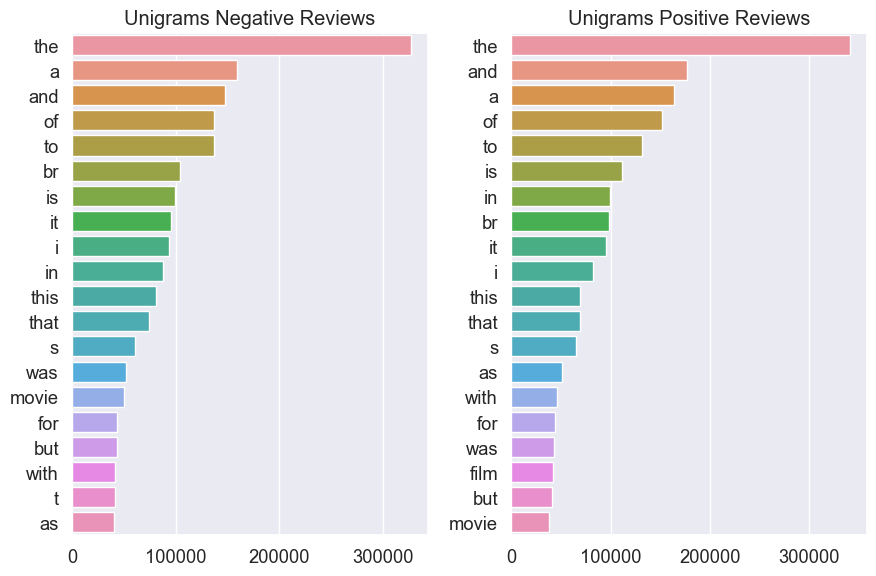

In [97]:
tokenizer = RegexpTokenizer(r'\w+')
df['tokens'] = df['review'].apply(tokenizer.tokenize)
df['tokens'] = df['tokens'].apply(lambda x: [w.lower() for w in x]) 
neg_unigrams = ngram_count(df[df['sentiment']==0]['tokens'], 1)
pos_unigrams = ngram_count(df[df['sentiment']==1]['tokens'], 1)

fig, axes = plt.subplots(1, 2, figsize=(9,6))
bins = 20
sns.barplot(x=list(neg_unigrams.values())[:bins], y=list(neg_unigrams.keys())[:bins], ax=axes[0])
sns.barplot(x=list(pos_unigrams.values())[:bins], y=list(pos_unigrams.keys())[:bins], ax=axes[1])

axes[0].set_title('Unigrams Negative Reviews')
axes[1].set_title('Unigrams Positive Reviews')

plt.tight_layout()
plt.show()

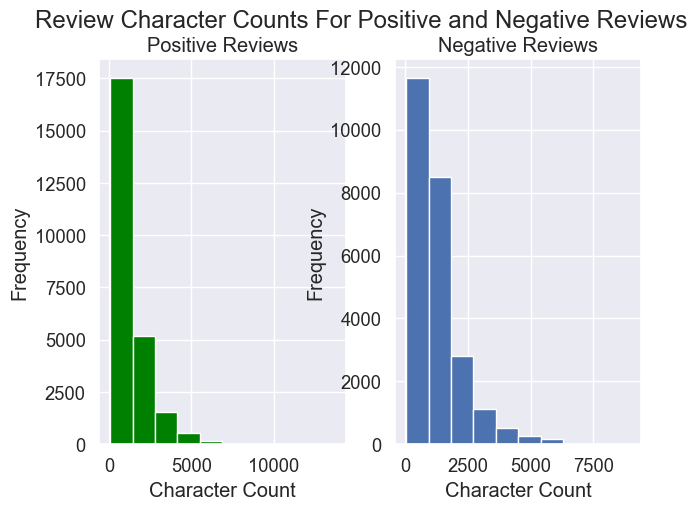

In [98]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 5))

text = df[df['sentiment'] == 1]['review'].str.len()
ax1.hist(text , color = 'green')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('Character Count')  # X label for the first subplot
ax1.set_ylabel('Frequency')        # Y label for the first subplot

text = df[df['sentiment'] == 0]['review'].str.len()
ax2.hist(text)
ax2.set_title('Negative Reviews')
ax2.set_xlabel('Character Count')  # X label for the second subplot
ax2.set_ylabel('Frequency')        # Y label for the second subplot

fig.suptitle('Review Character Counts For Positive and Negative Reviews')
plt.show()

## Pre Processing

In [9]:
def lemmatization(text):
    lemmatizer= WordNetLemmatizer()

    text = text.split()

    text=[lemmatizer.lemmatize(y) for y in text]
    
    return " " .join(text)

def remove_stop_words(text):

    Text=[i for i in str(text).split() if i not in stop_words]
    return " ".join(Text)

def remove_numbers(text):
    text=''.join([i for i in text if not i.isdigit()])
    return text

def lower_case(text):
    
    text = text.split()

    text=[y.lower() for y in text]
    
    return " " .join(text)

def remove_punctuations(text):
    ## Remove punctuations
    text = re.sub('[%s]' % re.escape("""!"#$%&'()*+,،-./:;<=>؟?@[\]^_`{|}~"""), ' ', text)
    text = text.replace('؛',"", )
    
    ## remove extra whitespace
    text = re.sub('\s+', ' ', text)
    text =  " ".join(text.split())
    return text.strip()

def remove_urls(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)

def clean(df):
    
    df.review=df.review.apply(lambda text : remove_stop_words(text))
    df.review=df.review.apply(lambda text : remove_numbers(text))
    df.review=df.review.apply(lambda text : remove_punctuations(text))
    df.review=df.review.apply(lambda text : remove_urls(text))
    df.review=df.review.apply(lambda text : lower_case(text))
    df.review=df.review.apply(lambda text : lemmatization(text))
    return df




  

In [10]:
df_clean = clean(df)

In [11]:
X= df_clean.review
y= df_clean.sentiment
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=100)


## Count Vectorizer

In [12]:
from sklearn.feature_extraction.text import CountVectorizer

In [13]:
# Create and fit the CountVectorizer on the training data
cv = CountVectorizer(max_features=1000)
X_train_counts = cv.fit_transform(X_train).toarray()

# Transform the testing data using the same CountVectorizer
X_test_counts = cv.transform(X_test).toarray()

In [14]:
# Map labels to numerical values
label_mapping = {'negative': 0, 'positive': 1}
y_train_mapped = y_train.map(label_mapping)
y_test_mapped = y_test.map(label_mapping)

In [15]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_counts)
X_test_scaled = scaler.transform(X_test_counts)

In [16]:
#set kfold split
kfold = KFold(n_splits=2, random_state=100, shuffle=True)

## Tree vs Ensemble Algorithms

Best parameters for Decision Tree:
{'criterion': 'gini', 'max_depth': 20}
Decision Tree: 0.721520 (0.001520)
Best parameters for Random Forest:
{'max_depth': None, 'n_estimators': 500}
Random Forest: 0.829800 (0.000120)
Best parameters for Adaptive Boosting:
{'learning_rate': 0.5, 'n_estimators': 200}
Adaptive Boosting: 0.834120 (0.001160)


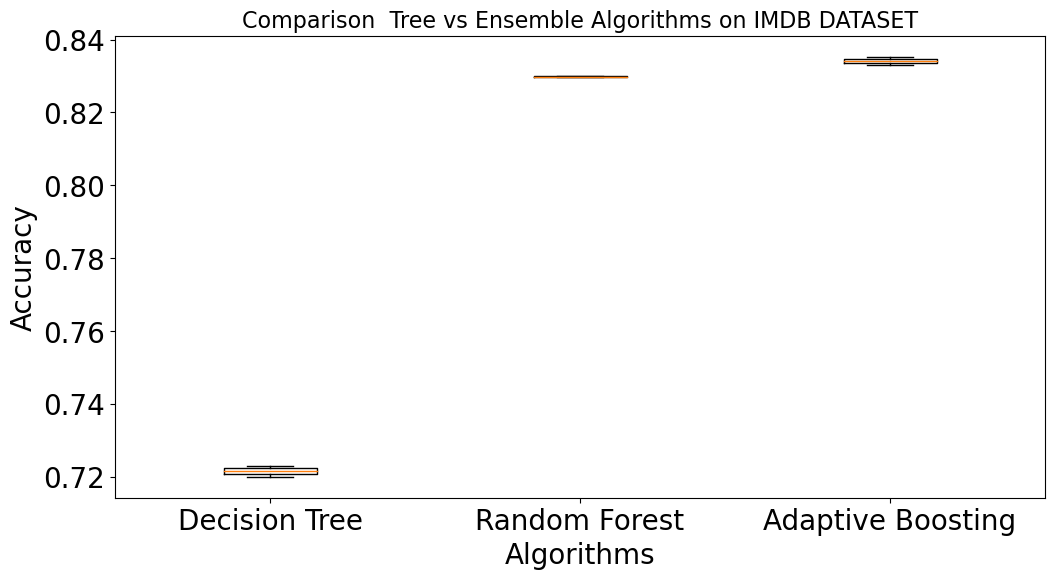

In [18]:
# Define the parameter grids for each algorithm
param_grid_dt = {'criterion': ['gini', 'entropy'], 'max_depth': [None, 5, 10,20]  }
param_grid_rf = {'n_estimators': [100, 200, 300,500], 'max_depth': [None, 5, 10,20] }
param_grid_ab = {'n_estimators': [50, 100, 150,200], 'learning_rate': [0.05 , 0.1, 0.5, 1.0]}
 
# Define the list of models with their respective parameter grids
models = []
models.append(('Decision Tree', DecisionTreeClassifier(), param_grid_dt))
models.append(('Random Forest', RandomForestClassifier(), param_grid_rf))
models.append(('Adaptive Boosting', AdaBoostClassifier(), param_grid_ab))
 
# Perform grid search and evaluate each model in turn
results = []
names = []
best_estimators = []
for name, model, param_grid in models:
    
    # Perform grid search
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=kfold, scoring='accuracy')
    grid_search.fit(X_train_counts, y_train)
    best_estimator = grid_search.best_estimator_
    best_estimators.append(best_estimator)
    # Print the best parameters
    print(f'Best parameters for {name}:')
    print(grid_search.best_params_)
    
    # Evaluate the best estimator
    cv_results = cross_val_score(best_estimator, X_train_counts, y_train, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))

plt.figure(figsize=(12, 6))  # Adjust the figure size as desired
plt.boxplot(results, labels=names)
plt.title('Comparison  Tree vs Ensemble Algorithms on IMDB DATASET', fontsize=16)  
plt.xlabel('Algorithms', fontsize=20)  
plt.ylabel('Accuracy', fontsize=20)  
plt.xticks(fontsize=20) 
plt.yticks(fontsize=20) 
plt.show()


Decision tree): ROC AUC=0.746
Random Forest: ROC AUC=0.910
AdaBoost): ROC AUC=0.921


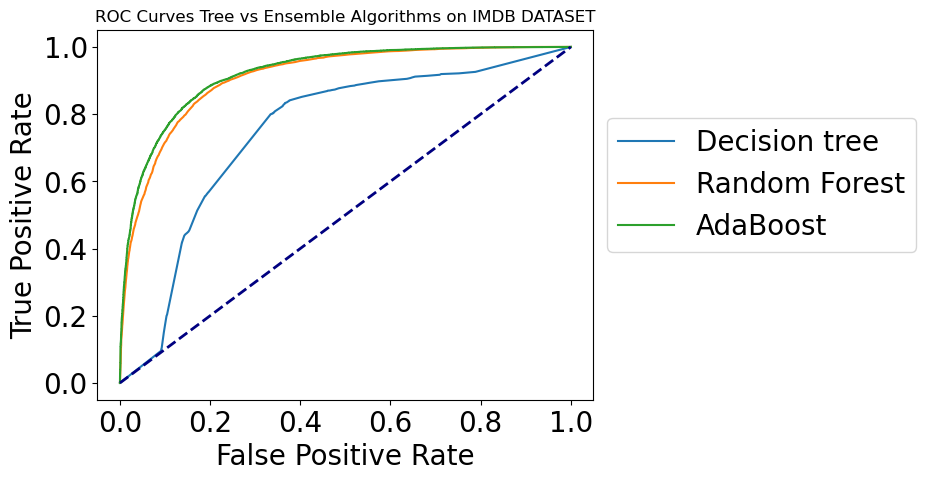

In [20]:
# Train  decision tree classifier
dtree = DecisionTreeClassifier(random_state=100, criterion= 'gini', max_depth = 20 )
dtree.fit(X_train_counts, y_train)
 
# Train  random forest classifier
rf = RandomForestClassifier(random_state=100, max_depth = None, n_estimators =500)
rf.fit(X_train_counts, y_train)
 
# Train  adaboost 
ada = AdaBoostClassifier(learning_rate = 0.5, n_estimators =200)
ada.fit(X_train_counts, y_train)
 


# predict probabilities for different models
lr_probs1 = dtree.predict_proba(X_test_counts)
lr_probs2 = rf.predict_proba(X_test_counts)
lr_probs3 = ada.predict_proba(X_test_counts)

# keep probabilities for the positive outcome only
lr_probs1 = lr_probs1[:, 1]
lr_probs2 = lr_probs2[:, 1]
lr_probs3 = lr_probs3[:, 1]


lr_auc1 = roc_auc_score(y_test, lr_probs1)
lr_auc2 = roc_auc_score(y_test, lr_probs2)
ada_auc = roc_auc_score(y_test, lr_probs3)

# summarize scores
print('Decision tree): ROC AUC=%.3f' % (lr_auc1))
print('Random Forest: ROC AUC=%.3f' % (lr_auc2))
print('AdaBoost): ROC AUC=%.3f' % (ada_auc))

# calculate roc curves

lr_fpr1, lr_tpr1, _ = roc_curve(y_test, lr_probs1)
lr_fpr2, lr_tpr2, _ = roc_curve(y_test, lr_probs2)
ada_fpr, ada_tpr, _ = roc_curve(y_test, lr_probs3)

# plot the roc curve for the model
plt.plot(lr_fpr1, lr_tpr1, linestyle='-' , label='Decision tree')
plt.plot(lr_fpr2, lr_tpr2,linestyle='-' , label='Random Forest')
plt.plot(ada_fpr, ada_tpr,linestyle='-' , label='AdaBoost')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# axis labels
plt.title('ROC Curves Tree vs Ensemble Algorithms on IMDB DATASET') 
plt.xlabel('False Positive Rate',fontsize=20)
plt.ylabel('True Positive Rate',fontsize=20)
plt.xticks(fontsize=20) 
plt.yticks(fontsize=20) 
# show the legend
plt.legend(bbox_to_anchor=[1, 0.8] , fontsize=20)
# show the plot
plt.show()


## Neural Networks

Best parameters for Perceptron:
{'eta0': 0.05, 'max_iter': 100}
Perceptron: 0.805000 (0.003400)
Best parameters for MLP:
{'hidden_layer_sizes': (20,), 'max_iter': 500, 'solver': 'adam'}
MLP: 0.827080 (0.000600)


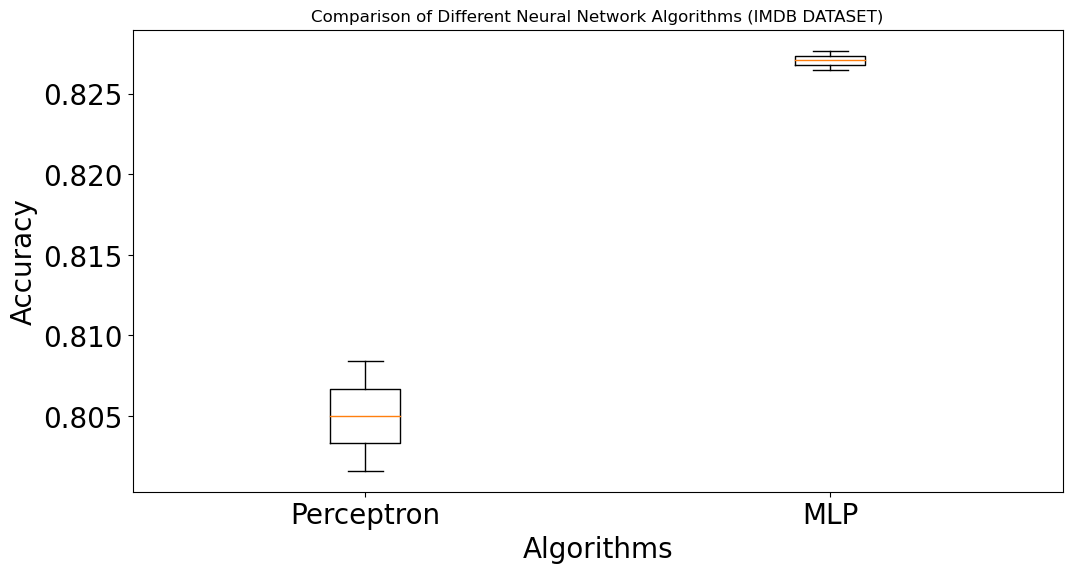

In [21]:
from sklearn.model_selection import KFold
# Define the parameter grids for each algorithm
param_grid_perceptron = {
                         'max_iter': [100 , 250 , 500,1000], 
    'eta0': [0.05 ,0.1, 0.01, 0.001] }
param_grid_mlp = {'hidden_layer_sizes': [(10,), (20,), (10, 10)],
                  'max_iter': [500 , 1000, 1500,2000] , 'solver' : ['lbfgs', 'sgd', 'adam']}


# Define the list of models with their respective parameter grids
models = []
models.append(('Perceptron', Perceptron(random_state=100), param_grid_perceptron))
models.append(('MLP', MLPClassifier(random_state=100), param_grid_mlp))

# Perform grid search and evaluate each model in turn
results = []
names = []
best_estimators = []
for name, model, param_grid in models:
    kfold = KFold(n_splits=2, random_state=100, shuffle=True)

    # Perform grid search
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=kfold, scoring='accuracy')
    grid_search.fit(X_train_scaled, y_train)
    best_estimator = grid_search.best_estimator_
    best_estimators.append(best_estimator)
    # Print the best parameters
    print(f'Best parameters for {name}:')
    print(grid_search.best_params_)

    # Evaluate the best estimator
    cv_results = cross_val_score(best_estimator, X_train_scaled, y_train, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))


plt.figure(figsize=(12, 6))  
plt.boxplot(results, labels=names)
plt.title('Comparison of Different Neural Network Algorithms (IMDB DATASET)') 
plt.xlabel('Algorithms', fontsize=20)  
plt.ylabel('Accuracy', fontsize=20)  
plt.xticks(fontsize=20) 
plt.yticks(fontsize=20) 
plt.show()



MLP: ROC AUC=0.902
Perceptron): ROC AUC=0.914


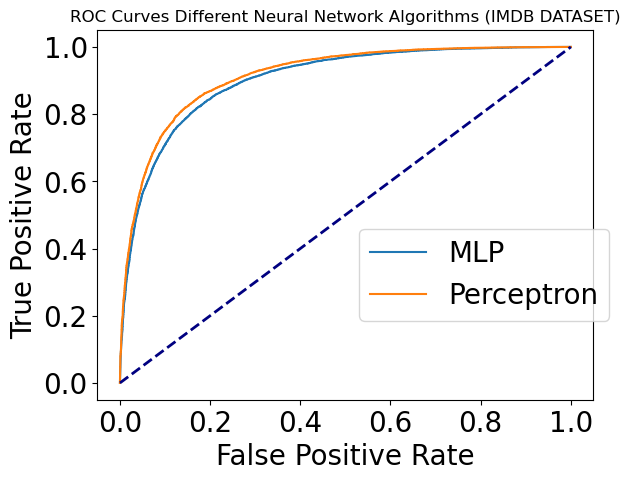

In [22]:
from sklearn.calibration import CalibratedClassifierCV
clf1 = MLPClassifier(random_state=100, hidden_layer_sizes=(20,), max_iter=500 , solver = 'adam' )
clf1.fit(X_train_scaled, y_train)


Ptron = Perceptron(eta0=0.05, random_state=100, max_iter=100)
clf2 = CalibratedClassifierCV(Ptron)
clf2.fit(X_train_scaled, y_train)



# predict probabilities for different models
lr_probs1 = clf1.predict_proba(X_test_scaled)
lr_probs2 = clf2.predict_proba(X_test_scaled)

# keep probabilities for the positive outcome only
lr_probs1 = lr_probs1[:, 1]
lr_probs2 = lr_probs2[:, 1]



# calculate accuracy score  
lr_auc1 = roc_auc_score(y_test, lr_probs1)
lr_auc2 = roc_auc_score(y_test, lr_probs2)

# summarize scores
print('MLP: ROC AUC=%.3f' % (lr_auc1))
print('Perceptron): ROC AUC=%.3f' % (lr_auc2))


lr_fpr1, lr_tpr1, _ = roc_curve(y_test, lr_probs1)
lr_fpr2, lr_tpr2, _ = roc_curve(y_test, lr_probs2)

# plot the roc curve for the model
plt.plot(lr_fpr1, lr_tpr1, linestyle='-' , label='MLP')
plt.plot(lr_fpr2, lr_tpr2,linestyle='-' , label='Perceptron')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# axis labels
plt.title('ROC Curves Different Neural Network Algorithms (IMDB DATASET)')
plt.xlabel('False Positive Rate' , fontsize=20)
plt.ylabel('True Positive Rate' ,  fontsize=20)
plt.xticks(fontsize=20) 
plt.yticks(fontsize=20) 
# show the legend
plt.legend(bbox_to_anchor=[0.5, 0.5] , fontsize=20)
# show the plot
plt.show()


## KNN

In [23]:
knn_model = KNeighborsClassifier()

In [25]:
param_grid= {'n_neighbors':range(1,50), 'metric': ['minkowski','manhattan','euclidean']}
knn_grid_model = GridSearchCV(knn_model,param_grid)
knn_grid_model.fit(X_train_scaled,y_train)
print(knn_grid_model.best_params_)

{'metric': 'minkowski', 'n_neighbors': 30}


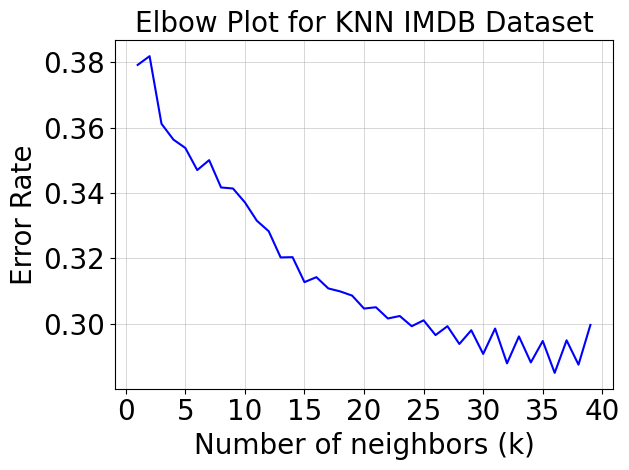

In [26]:
# Calculate error rate for different k values
k_values = range(1, 40)
error_rates = []
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k, metric='minkowski')
    knn.fit(X_train_scaled, y_train)
    y_pred = knn.predict(X_test_scaled)
    error_rate = 1 - knn.score(X_test_scaled, y_test)  # Calculate error rate as 1 - accuracy
    error_rates.append(error_rate)

# Plot the error rate curve
plt.plot(k_values, error_rates, linestyle='-', color='b')
plt.xlabel('Number of neighbors (k)', fontsize=20)
plt.ylabel('Error Rate', fontsize=20)
plt.title('Elbow Plot for KNN IMDB Dataset', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(True, linestyle='-', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()

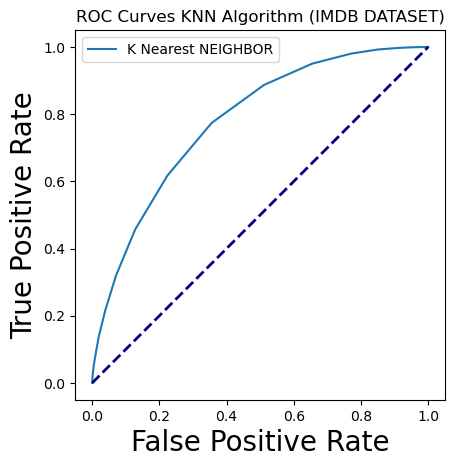

In [28]:
knn_probs = knn_grid_model.predict_proba(X_test_scaled)

# keep probabilities for the positive outcome only
knn_probs = knn_probs[:, 1]

# calculate knn auc
knn_auc = roc_auc_score(y_test, knn_probs)
 # Calculate the ROC curves
knn_fpr, knn_tpr, _ = roc_curve(y_test, knn_probs)
 
# Plot the ROC curves with custom styling  
plt.plot(knn_fpr, knn_tpr, label='K Nearest NEIGHBOR')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# Axis labels
plt.title('ROC Curves KNN Algorithm (IMDB DATASET)')
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20)

# Set the aspect ratio to be equal
plt.gca().set_aspect('equal')

# Show the legend
plt.legend()

# Show the plot
plt.show()

## Bayesian Learning

Gaussian NB: 0.801360 (0.003600)
Multinomial NB: 0.830440 (0.004360)


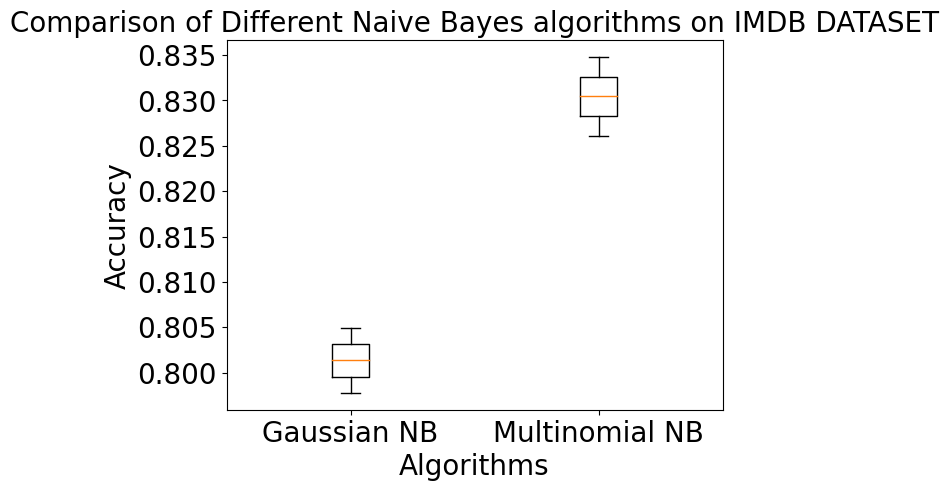

In [30]:
# Spot Check Algorithms
models = []
models.append(('Gaussian NB', GaussianNB()))
models.append(('Multinomial NB', MultinomialNB()))

# evaluate each model in turn
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=2, random_state=101, shuffle=True)
    cv_results = cross_val_score(model, X_train_counts, y_train, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))

# Compare Algorithms
plt.boxplot(results, labels=names)
plt.title('Comparison of Different Naive Bayes algorithms on IMDB DATASET', fontsize=20)
plt.xlabel('Algorithms', fontsize=20)  
plt.ylabel('Accuracy', fontsize=20)  
plt.xticks(fontsize=20) 
plt.yticks(fontsize=20) 
plt.show()

GNB: ROC AUC=0.871
MNB): ROC AUC=0.905


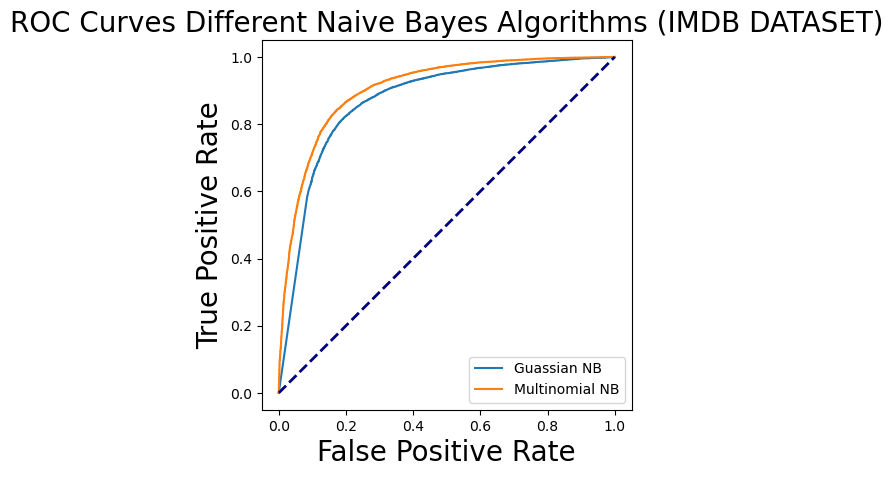

In [32]:
gnb = GaussianNB()
gnb.fit(X_train_counts, y_train)

mnb = MultinomialNB()
mnb.fit(X_train_counts, y_train)

gnb_probs = gnb.predict_proba(X_test_counts)
mnb_probs = mnb.predict_proba(X_test_counts)

# keep probabilities for the positive outcome only
gnb_probs = gnb_probs[:, 1]
mnb_probs = mnb_probs[:, 1]

# calculate accuracy score different MLP models
gnb_auc = roc_auc_score(y_test, gnb_probs)
mnb_auc = roc_auc_score(y_test, mnb_probs)
 
 # Calculate the ROC curves
gnb_fpr, gnb_tpr, _ = roc_curve(y_test, gnb_probs)
mnb_fpr, mnb_tpr, _ = roc_curve(y_test, mnb_probs)
# summarize scores
print('GNB: ROC AUC=%.3f' % (gnb_auc))
print('MNB): ROC AUC=%.3f' % (mnb_auc))
# Plot the ROC curves with custom styling and thinner lines
plt.plot(gnb_fpr, gnb_tpr, label='Guassian NB')
plt.plot(mnb_fpr, mnb_tpr,  label='Multinomial NB')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# Axis labels
plt.title('ROC Curves Different Naive Bayes Algorithms (IMDB DATASET)',fontsize=20)
plt.xlabel('False Positive Rate' , fontsize=20)
plt.ylabel('True Positive Rate' , fontsize=20)

# Set the aspect ratio to be equal
plt.gca().set_aspect('equal')

# Show the legend
plt.legend()

# Show the plot
plt.show()

## Final Evaluation

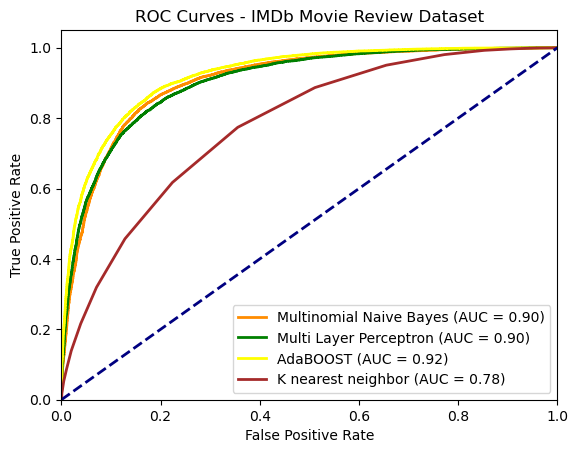

In [33]:
# Plot the ROC curves
plt.figure()
plt.plot(mnb_fpr, mnb_tpr, color='darkorange', lw=2, label='Multinomial Naive Bayes (AUC = %0.2f)' % mnb_auc)
plt.plot(lr_fpr1, lr_tpr1, color='green', lw=2, label='Multi Layer Perceptron (AUC = %0.2f)' %  lr_auc1)
plt.plot(ada_fpr, ada_tpr, color='yellow', lw=2, label='AdaBOOST (AUC = %0.2f)' % ada_auc)
plt.plot(knn_fpr, knn_tpr, color='brown', lw=2, label='K nearest neighbor (AUC = %0.2f)' % knn_auc)

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - IMDb Movie Review Dataset')
plt.legend(loc='lower right')
plt.show()

In [34]:
##Classification Report Best Model
from sklearn.metrics import classification_report , confusion_matrix,accuracy_score
ada_preds = ada.predict(X_test_counts)
print(classification_report(y_test, ada_preds))

              precision    recall  f1-score   support

           0       0.86      0.82      0.84     12486
           1       0.83      0.87      0.85     12514

    accuracy                           0.84     25000
   macro avg       0.84      0.84      0.84     25000
weighted avg       0.84      0.84      0.84     25000



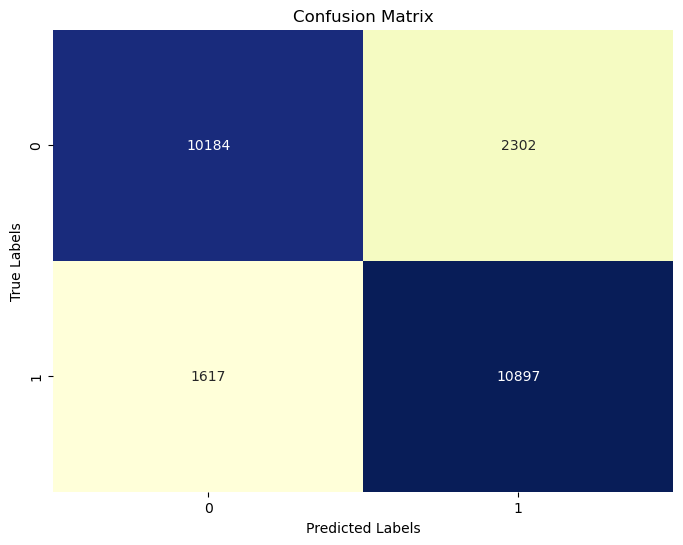

In [35]:
##Confusion matrix Best Model
cm = confusion_matrix(y_test,ada_preds)
# Display confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='YlGnBu', fmt='d', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()